<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PreferredAI/tutorials/blob/master/recommender-systems/04_implicit_feedback.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/PreferredAI/tutorials/blob/master/recommender-systems/04_implicit_feedback.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Implicit Feedback


There are two types of feedback on which most recommender systems would be based. Explicit feedback deals with clear and quantified expression of preferences by a user, in terms of both likes and dislikes. An excellent example would be ratings. However, much more common is implicit feedback, where users provide some positive signals, but the contrast to negative signals may be absent or at least much less evident. An example would be clicks on links or views when browsing.  In this tutorial, we will focus on implicit feedback.

## 1. Setup

In [1]:
!pip install --quiet cornac==2.3.2 adjustText

In [2]:
import os
import sys
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
%matplotlib inline

import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import MF, BPR, WMF

import tensorflow as tf

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

SEED = 42
VERBOSE = False

System version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Cornac version: 2.3.2
Tensorflow version: 2.18.0


## 2. Weighted Matrix Factorization (WMF)

We use the term **adoption matrix** to refer to interactions between users and items.  In the case of explicit feedback, it is the rating matrix, while in the case of implicit feedback, it can be a matrix of click counts or binary.

Weighted matrix factorization predicts an adoption of user $i$ to item $j$ using inner product of user and item factors as $\hat{p}_{i,j} = \mathbf{u}_i^T \mathbf{v}_j$.  The difference between Weighted MF and Original MF is that WMF tries to predict *unobserved* adoptions while MF ignores them during training. The convention by Cornac library is to derive observed and unobserved adoptions from the rating matrix as follows.

\begin{equation}
p_{i,j} =
\begin{cases}
r_{i, j} &\mbox{if } r_{i,j} > 0 \\
0 & \mbox{otherwise}
\end{cases}
\end{equation}

The important principle is that WMF usually assigns a higher confidence weight when fitting *observed* adoptions than when fitting *unobserved* adoptions. There are several ways to introduce the confidence scores.  Here we use the convention by Cornac library, which implements the following rules:

\begin{equation}
c_{i,j} =
\begin{cases}
a &\mbox{if } r_{i,j} > 0 \\
b & \mbox{otherwise }
\end{cases}
\end{equation}

Concretely, WMF minimizes the following loss function:

$$ \mathcal{L}(\mathbf{U,V}|\lambda) = \frac{1}{2} \sum_{i,j} c_{i,j} (p_{i,j} - \mathbf{u}_i^T \mathbf{v}_j)^2 + \frac{\lambda}{2} \sum_{i=1}^{N} ||\mathbf{u}_i||^2 + \frac{\lambda}{2} \sum_{j=1}^{M} ||\mathbf{v}_j||^2 $$

Let's now compare how WMF and MF are different.

In [3]:
K = 50
wmf = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")
mf = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.01,
        verbose=VERBOSE, seed=SEED, name=f"MF(K={K})")

eval_metrics = [
  cornac.metrics.RMSE(),
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=10),
  cornac.metrics.Recall(k=10),
  cornac.metrics.FMeasure(k=10),
  cornac.metrics.NDCG(k=[10, 20, 30]),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
]

data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[wmf, mf], metrics=eval_metrics).run()


TEST:
...
          |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@30 | Precision@10 | Recall@10 | Train (s) | Test (s)
--------- + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------------ + --------- + --------- + --------
WMF(K=50) | 1.1012 | 0.8980 | 0.1404 | 0.1697 | 0.4586 |  0.2414 |  0.2526 |  0.2714 |       0.2022 |    0.1457 |   11.1925 |   4.1312
MF(K=50)  | 0.8909 | 0.6573 | 0.0454 | 0.0564 | 0.2288 |  0.1021 |  0.0942 |  0.0967 |       0.0928 |    0.0358 |    0.2022 |   2.7004



As we can observe, the strength of the MF model is the ability to predict ratings well (lower RMSE). However, WMF model is designed to rank items, by fitting binary adoptions, thus it outperforms MF across all the listed ranking metrics.

## 3. Bayesian Personalized Ranking (BPR)

Implicit feedback can also be turned into another form of expression, namely ordinal preferences.  Given an *observed* feedback $(i, j)$ between user $i$ and item $j$, another item $l$ (with *no observed interaction* with user $i$) is coupled with the pair to form a triple $(i, j, l)$.  Thus, there are now notions of *positive* and *negative* items.  The training data consists of ordinal triples $D_S = \{(i, j, l) | r_{ij} \in \mathbf{R}^+ \land r_{il} \in \mathbf{R}^-\}$.

BPR maximizes the joint probability over all triples:

$$ \prod_{(i,j,l) \in D_S} p(j >_{i} l) = \prod_{(i,j,l) \in D_S} \sigma(\mathbf{u}_i^T \mathbf{v}_j - \mathbf{u}_i^T \mathbf{v}_l) $$

where $\sigma(*)$ is the logistic *sigmoid* function and the preference scoring function is the inner product of user and item latent factors, inspired by the matrix factorization method.

By minimizing *negative log-likelihood* with *l2-regularization*, we arrive at the following loss function:

$$ \mathcal{L}(\mathbf{U,V}|\lambda) = \sum_{i,j,l} \ln (1 + \exp\{-(\mathbf{u}_i^T \mathbf{v}_j - \mathbf{u}_i^T \mathbf{v}_l)\}) + \frac{\lambda}{2} \sum_{i=1}^{N} ||\mathbf{u}_i||^2 + \frac{\lambda}{2} \sum_{j=1}^{M} ||\mathbf{v}_j||^2 $$

Let's compare the two models BPR and WMF.

In [4]:
K = 50
bpr = BPR(k=K, max_iter=200, learning_rate=0.01, lambda_reg=0.001,
          verbose=VERBOSE, seed=SEED, name=f"BPR(K={K})")
wmf = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")

rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
cornac.Experiment(eval_method=rs, models=[bpr, wmf], metrics=eval_metrics).run()


TEST:
...
          |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@30 | Precision@10 | Recall@10 | Train (s) | Test (s)
--------- + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------------ + --------- + --------- + --------
BPR(K=50) | 1.5631 | 0.9356 | 0.2197 | 0.2667 | 0.6320 |  0.3865 |  0.3856 |  0.4030 |       0.3236 |    0.2229 |    3.4756 |   2.0617
WMF(K=50) | 1.1012 | 0.8980 | 0.1404 | 0.1697 | 0.4586 |  0.2414 |  0.2526 |  0.2714 |       0.2022 |    0.1457 |    5.6794 |   2.2022



BPR only tries to preserve the ordinal constraints without learning to predict the rating values.  Thus, RMSE is not the right metric to evaluate BPR model.   Minimizing the loss function of BPR is analogous to maximizing AUC, therefore, we expect BPR to do well on that metric.

Both BPR and WMF models are designed to obtain good performances in terms of ranking metrics.  With reasonable efforts for hyper-parameter tuning, we should see comparable performance between the two models.  

## 4. Interpreting Latent Factors

Both presented models (WMF and BPR) are based on the matrix factorization technique, let us see how the latent factors could give us some information about how items are associated with one another, as well as which items tend to be associated with a particular factor.

In [5]:
# Download some information of MovieLens 100K dataset
item_df = pd.read_csv(
  cache("http://files.grouplens.org/datasets/movielens/ml-100k/u.item"),
  sep="|", encoding="ISO-8859-1",
  names=["ItemID", "Title", "Release Date", "Video Release Date", "IMDb URL",
         "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
         "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
         "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
).set_index("ItemID").drop(columns=["Video Release Date", "IMDb URL", "unknown"])

### WMF Latent Factors

Below is the variance of each latent dimension across different items.  If a factor or dimension has higher variance, it is better at discriminating among different items.  Conversely, if the variance of a factor is too small, it implies that most items would have a similar value for that factor.

<ipython-input-6-1c7bf660117b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);


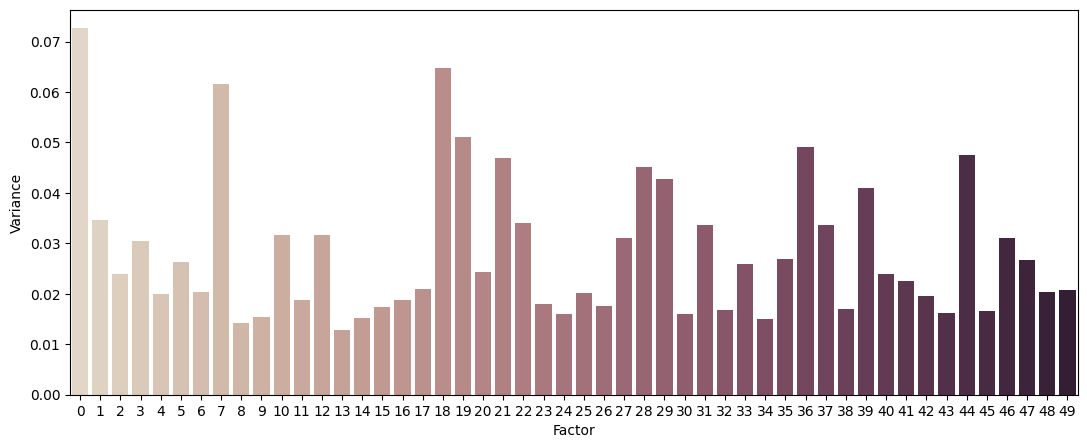

In [6]:
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(wmf.V, axis=0)})
fig, ax = plt.subplots(figsize=(13, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);

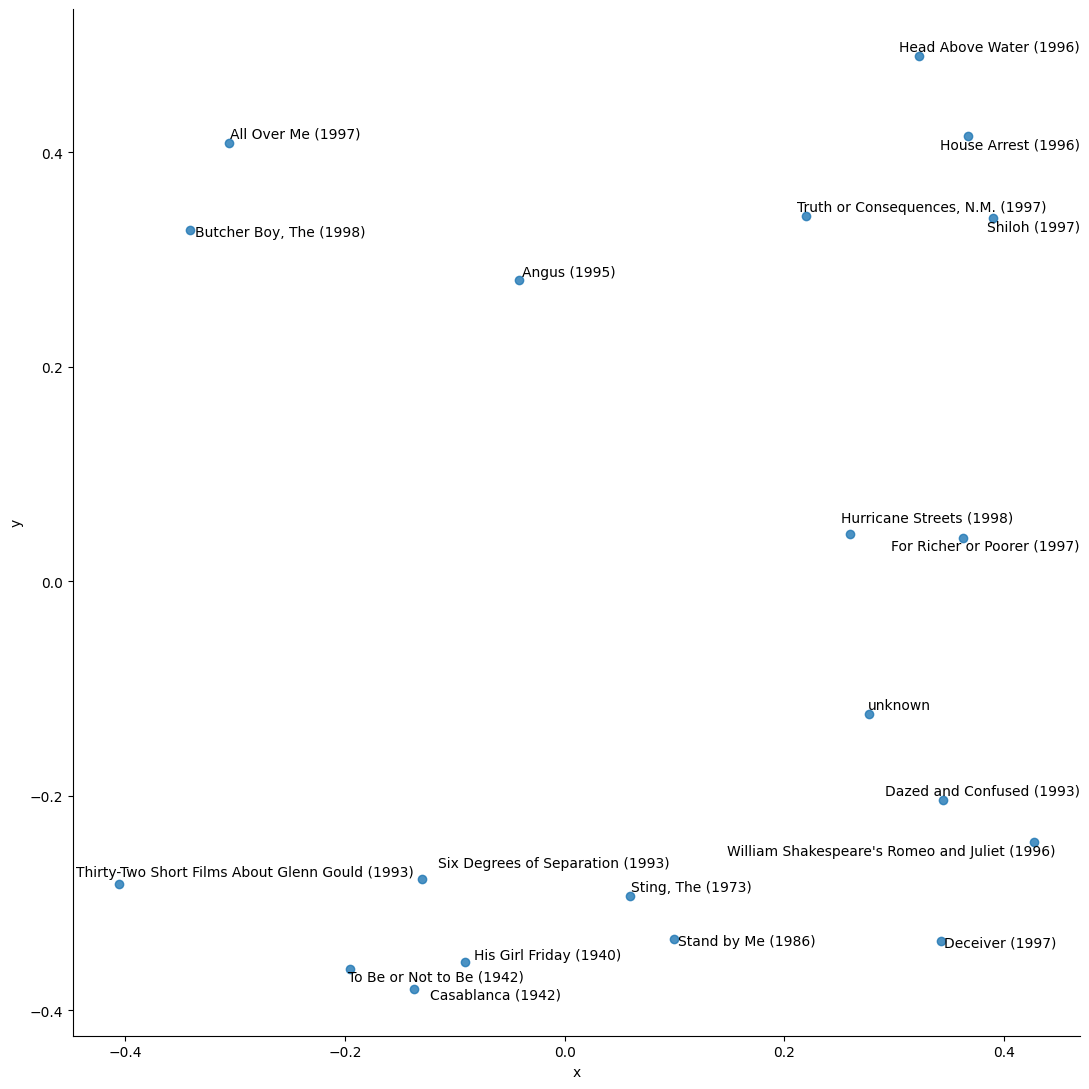

In [7]:
TOP2F = (0, 18)
SAMPLE_SIZE = 20

rng = np.random.RandomState(SEED)
sample_inds = rng.choice(np.arange(wmf.V.shape[0]), size=SAMPLE_SIZE, replace=False)
sample_df = pd.DataFrame(data=wmf.V[sample_inds][:, TOP2F], columns=["x", "y"])

sns.lmplot(x="x", y="y", data=sample_df, height=11.0, fit_reg=False)
item_idx2id = list(wmf.train_set.item_ids)
titles = item_df.loc[[int(item_idx2id[i]) for i in sample_inds]]["Title"].values
adjust_text(
  [plt.text(*sample_df.loc[i].values, titles[i], size=10) for i in range(len(titles))]
);

### Interpreting Recommendations of WMF

Let's pick a user and see what the top-K recommendations by WMF model are.  

In [8]:
UIDX = 0
TOPK = 5

item_id2idx = wmf.train_set.iid_map
item_idx2id = list(wmf.train_set.item_ids)

recommendations, scores = wmf.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS:")
print("Scores:", scores[recommendations[:TOPK]])
item_df.loc[[int(item_idx2id[i]) for i in recommendations[:TOPK]]]


TOP 5 RECOMMENDATIONS:
Scores: [4.5135574 4.4660473 4.317131  4.2535973 4.2024813]


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
318,Schindler's List (1993),01-Jan-1993,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
50,Star Wars (1977),01-Jan-1977,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
496,It's a Wonderful Life (1946),01-Jan-1946,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
64,"Shawshank Redemption, The (1994)",01-Jan-1994,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


The solution of alternating least squares model can be used to explain the recommendations.  Please refer to Section 5 in the [paper](http://yifanhu.net/PUB/cf.pdf) for more details.  In summary, the predicted preference of user $i$ for item $j$ is rewritten as:

$$ \hat{p}_{i,j} = \sum_{l=1}^M sim_i (j, l) c_{i, l} p_{i,l} $$

where $sim_i (j, l)$ is the similarity between item $j$ and item $l$ from user $i$’s viewpoint.


Let's try to explain why the WMF model recommends the movie **Star Wars (1977)**, *ItemID* = 50 to the user.

In [9]:
REC_ID = 50
print("Recommended movie:", item_df.loc[REC_ID].Title)
rec_idx = item_id2idx[str(REC_ID)]

U, V, lbd = wmf.U, wmf.V, wmf.lambda_v
pi = wmf.train_set.matrix[UIDX].toarray().ravel()
ci = (pi > 0) * (wmf.a - wmf.b) + wmf.b

Wu = np.linalg.inv(V.T.dot(np.diag(ci)).dot(V) + lbd * np.eye(wmf.k))
sim = V[rec_idx].dot(Wu).dot(V.T)
contribution = sim * ci * pi

print("\nTop contributors:")
df = defaultdict(list)
for idx in np.argsort(contribution)[-TOPK:][::-1]:
  df["ItemID"].append(item_df.loc[[int(item_idx2id[idx])]].index.values[0])
  df["Title"].append(item_df.loc[[int(item_idx2id[idx])]]["Title"].values[0])
  df["Similarity"].append(sim[idx])
  df["Confidence"].append(ci[idx])
  df["Adoption"].append(pi[idx])
  df["Contribution"].append(contribution[idx])
pd.DataFrame.from_dict(df)

Recommended movie: Star Wars (1977)

Top contributors:


,ItemID,Title,Similarity,Confidence,Adoption,Contribution
0,258,Contact (1997),0.241276,1.0,4.0,0.965103
1,237,Jerry Maguire (1996),0.231643,1.0,4.0,0.926570
2,971,Mediterraneo (1991),0.205749,1.0,4.0,0.822998
3,56,Pulp Fiction (1994),0.140435,1.0,5.0,0.702177
4,690,Seven Years in Tibet (1997),0.115898,1.0,4.0,0.463591


### BPR Latent Factors

Below is the variance of each latent dimension.

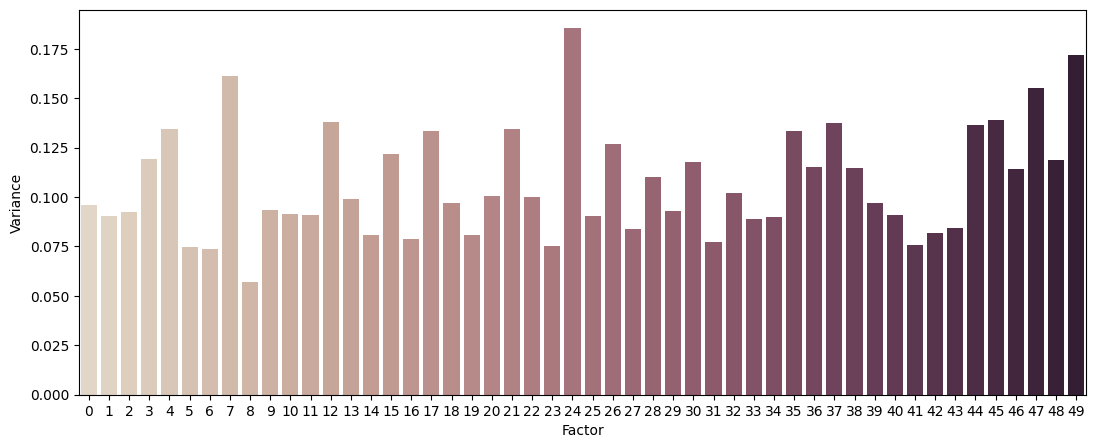

In [10]:
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(bpr.i_factors, axis=0)})
fig, ax = plt.subplots(figsize=(13, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax, hue="Factor", legend=False);

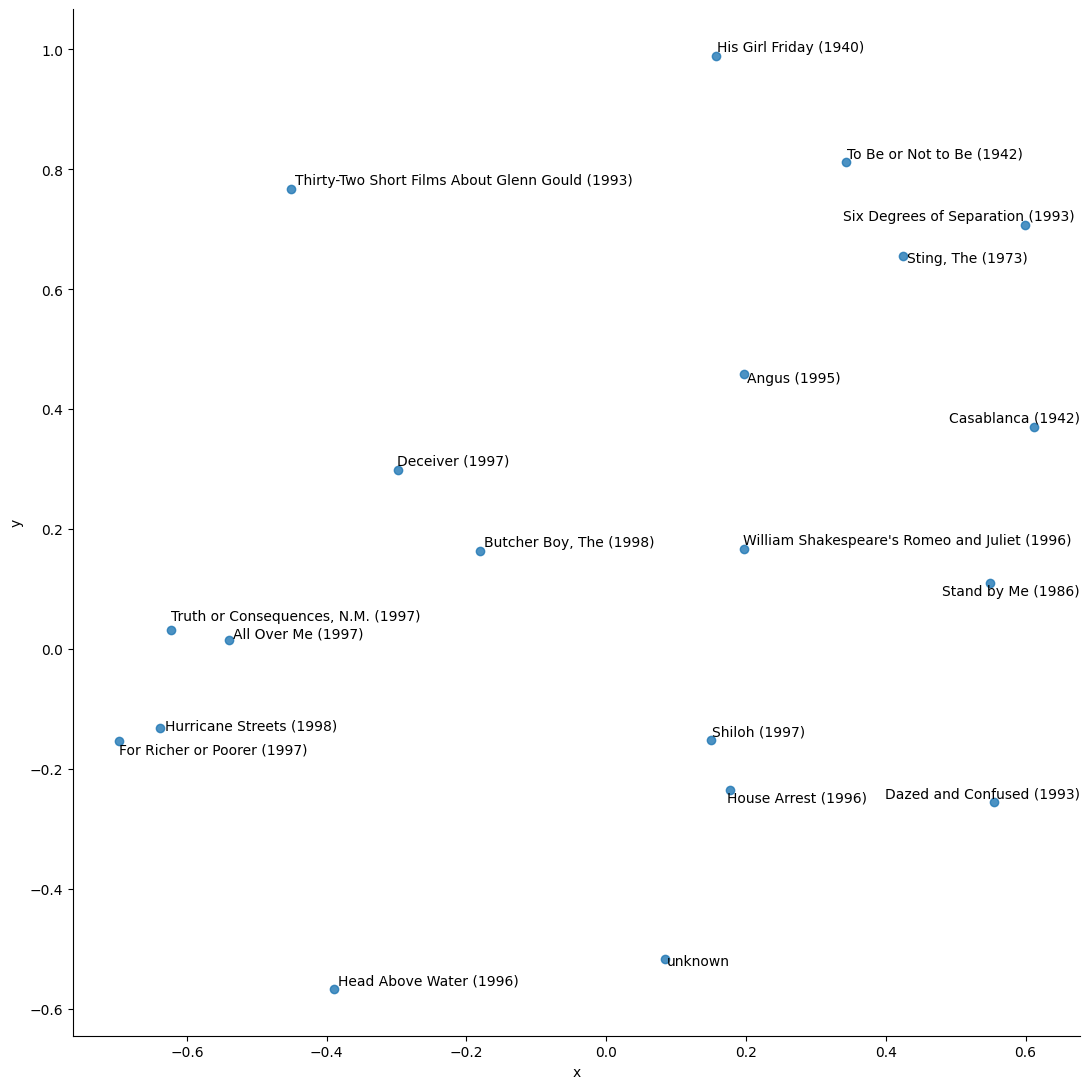

In [11]:
TOP2F = (24, 49)
SAMPLE_SIZE = 20

rng = np.random.RandomState(SEED)
sample_inds = rng.choice(np.arange(bpr.i_factors.shape[0]), size=SAMPLE_SIZE, replace=False)
sample_df = pd.DataFrame(data=bpr.i_factors[sample_inds][:, TOP2F], columns=["x", "y"])

sns.lmplot(x="x", y="y", data=sample_df, height=11.0, fit_reg=False)
item_idx2id = list(bpr.train_set.item_ids)
titles = item_df.loc[[int(item_idx2id[i]) for i in sample_inds]]["Title"].values
adjust_text(
  [plt.text(*sample_df.loc[i].values, titles[i], size=10) for i in range(len(titles))]
);

## References

1.   Aggarwal, C. C. (2016). Recommender systems (Vol. 1). Cham: Springer International Publishing.
2.   Hu, Y., Koren, Y., & Volinsky, C. (2008, December). Collaborative filtering for implicit feedback datasets. In 2008 Eighth IEEE International Conference on Data Mining (pp. 263-272). Ieee.
3.   Rendle, S., Freudenthaler, C., Gantner, Z., & Schmidt-Thieme, L. (2012). BPR: Bayesian personalized ranking from implicit feedback. arXiv preprint arXiv:1205.2618.   
4.   Cornac - A Comparative Framework for Multimodal Recommender Systems (https://cornac.preferred.ai/)
5.   https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/cornac_bpr_deep_dive.ipynb

